# Example Notebook for Correcting and loading FastCCD Images

This example reads data from the FastCCD and corrects and rotates the images. Included are some
example of widgets to interact with the data

## Getting Started

Load the ``databroker`` moudle, ``csxtools`` and various other dependencies

In [1]:
import numpy as np
from databroker import DataBroker, get_table, get_images, get_events
from csxtools.utils import get_fastccd_images, get_fastccd_timestamps
from csxtools.ipynb import image_stack_to_movie, show_image_stack
%matplotlib notebook
from matplotlib import pyplot as plt

Set the logger level to info to see logging output, if required!

In [2]:
import logging
logging.getLogger().setLevel(logging.INFO)

## Get the data headers from the DataBroker!

In [3]:
bgnd = DataBroker['ce5042b7-00ae-49ca-9b11-b10c5661aaaa'] #[52440]

INFO:databroker.databroker:Interpreting key = ce5042b7-00ae-49ca-9b11-b10c5661aaaa as a str


## Get the timestamps

In [4]:
timestamps = get_fastccd_timestamps(bgnd)

<IPython.core.display.Javascript object>


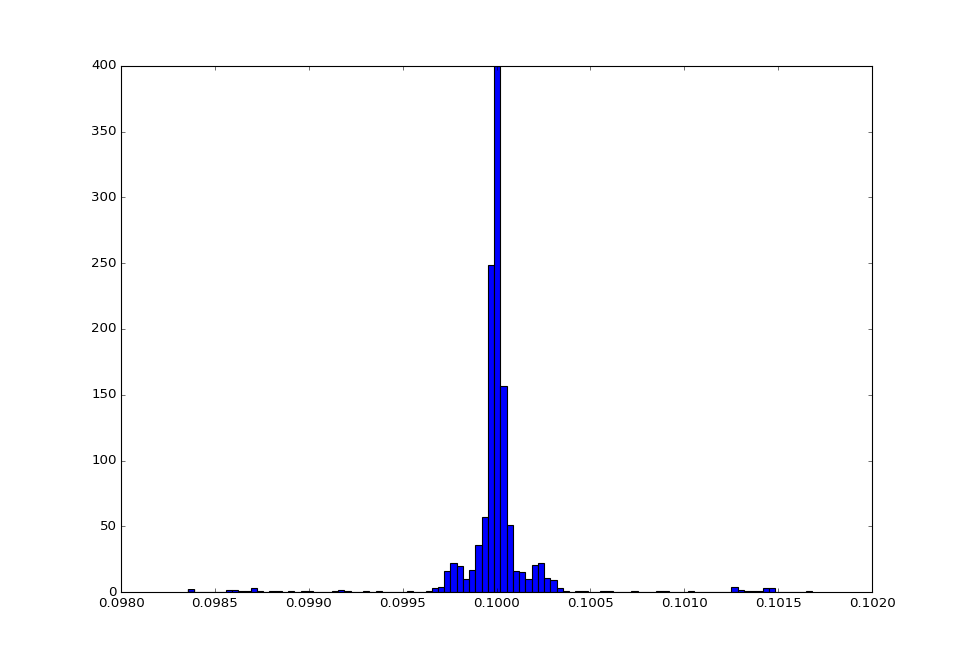

In [5]:
diff = np.diff(timestamps)
fig, axes = plt.subplots(1)
n = axes.hist(diff, bins=100)

In [6]:
timestamps

array([  8.14320518e+08,   8.14320518e+08,   8.14320518e+08, ...,
         8.14320638e+08,   8.14320638e+08,   8.14320638e+08])

In [7]:
import csxtools
csxtools.__version__

'0.1.6+0.g0110635.dirty'

In [8]:
import filestore
filestore.__version__

'0.2.2+17.g3a6f637'

In [9]:
import databroker
databroker.__version__

'0.3.2+6.g972ef05'